### This is a example notebook that demonstrates how to train a binary classifier using VGG16

**Dataset used**: Dogs vs cats. Download the `train.zip` from this [link](https://www.kaggle.com/c/dogs-vs-cats/data)

**Directory structure** : Refer this [blog](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) for the directory structure

NOTE: Split the data from the train.zip folder into subdirectories train, valid (in reference to the blog)

**Architecture used** : VGG16 

** pretrained weights path** : Download the imagenet pretrained weights from [this](https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5) path and save it in a directory

**Caution** :  Make sure your keras version is >= 2.1.2

In [1]:
import keras
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.optimizers import adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.
/home/abhijit/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# check keras version
print(keras.__version__)

2.1.2


In [3]:
input_shape = (224,224,3) # can be any shape even (None,None,3) but it is advised not to use  (None,None,3).
epochs = 30
train_dir = "/specify/path/to/train" # refer directory structure (use \ in windows)
valid_dir = "/specify/path/to/valid" # refer directory structure (use \ in windows)
classes = 2

In [4]:
vgg16 = VGG16(include_top=False, # Top layer has 2 4096 Dense and 1 1000 output  softmax classifier lets strip it off
              input_shape=input_shape,
              weights='imagenet')
# if you are doing this for the first time, Keras will download imagenet weights

As of now the variable `vgg16` only has Convolutional We need to add the 2 Dense layers and the final classification layers. We cannot load teh Dense layers of VGG16 pretrained on `imagenet` because, The Dense (Fully connected) layers are dependent on input shape where as the Conv layers are independent of input shape (Thats why in subsequent years Fully convolutional architectures were developed (Resnet, Inception etc)) and the 4096 neurons in the Last layers are connected to 1000 classes (imagenet number of classes) Thus we need to define them manually

In [5]:
# we can use both Sequential or Functional API to define the model. We defined it using the Functional API
# Remember vgg16 is an instance of class keras.engine.training.model
x = Flatten(name="flatten")(vgg16.output) # First flatten the Output from the Conv layes so that you can map it to FC layers
x = Dense(4096,activation='relu',name="Dense1")(x)
x = Dense(4096,activation='relu',name="Dense2")(x)
prediction = Dense(classes,activation='softmax',name="prediction")(x)
model = Model(inputs=vgg16.input,outputs=prediction)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

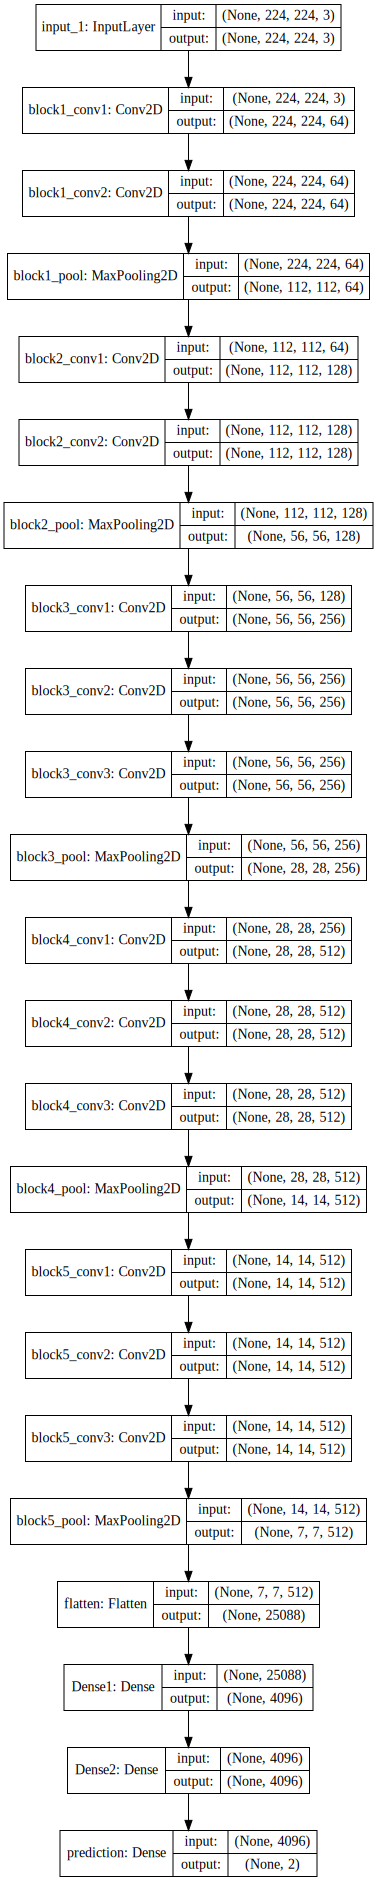

In [6]:
# visualize the model 
SVG(model_to_dot(model,show_layer_names=True,show_shapes=True).create(prog='dot', format='svg')) # This works only in jupyter notebook
# comment the above line and uncomment the below lines to save model as a png file (when working from spyder) 
# from keras.utils import plot_model
# plot_model(model, to_file='./vgg16_model.png',show_shapes=True,show_layer_names=True)

In [7]:
#compile the model
model.compile(loss ='categorical_crossentropy',optimizer=adam(lr=0.001), metrics=['accuracy'])

In [8]:
def preprocess_input(img):
    # preprocessing funtion for VGG16 (Channel wise mean subtraction)
    # img must be in RGB format
    # pass this function as an argument to ImageDataGenerator
    mean = [123.68, 116.779, 103.939]
    img[0, :, :] -= mean[0]
    img[1, :, :] -= mean[1]
    img[2, :, :] -= mean[2]
    return(img)

In [9]:
logdir = "path/to/tensorboard/log/dir"
checkpoint_path = "path/to/checkpoint.h5"
tensorboard = TensorBoard(log_dir=logdir,write_graph=True)
model_checkpoint = ModelCheckpoint(monitor='val_loss',filepath=checkpoint_path,save_best_only=True,save_weights_only=False)
reducelr = ReduceLROnPlateau(monitor='val_loss',patience=10,factor=0.1,min_lr=0.000001)
callbacks_list = [tensorboard,model_checkpoint,reducelr]

From here on follow the official [tutorial](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) 

The steps are as follows:
* Use ImageDataGenerator() and use flow_from_directory()
* While defining the ImageDataGenerator() pass the above preprocess_input as an argument to preprocessing_function. Refer [Docs](https://keras.io/preprocessing/image/)
* Use model.fit_generator() 
* pass the above callbacks_list to callbacks argument in fit_generator(). Refer [Docs](https://keras.io/models/model/)
* Run `tensorboard --logdir=path/to/tensorboard/log/dir` from the **command line** or **terminal** to visualize live plots and graph on Tensorboard